In [214]:
!pip install statsmodels geopandas descartes

    100% |################################| 901kB 2.4MB/s ta 0:00:011
    100% |################################| 1.5MB 2.0MB/s ta 0:00:011
    100% |################################| 17.9MB 863kB/s ta 0:00:01
    100% |################################| 11.2MB 722kB/s ta 0:00:011
    100% |################################| 40kB 1.9MB/s ta 0:00:01
  Running setup.py bdist_wheel for munch ... done
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch
  Found existing installation: cligj 0.4.0
    Uninstalling cligj-0.4.0:
      Successfully uninstalled cligj-0.4.0
You are using pip version 18.0, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import numpy as np
from scipy import stats

In [87]:
def R2(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results

In [2]:
ds = pd.read_csv('./data/processed/TERRACLIMATE_processed.csv')
ds.index = pd.to_datetime(ds.index)
ndvi = pd.read_csv('./data/csv/LANDSAT_NDVI_EVI_ikhnart_v1_long_2019-06-24.csv')
ndvi.index = pd.to_datetime(ndvi.img_date)
ipoints = pd.read_csv('./data/csv/ikhnart_points_v1.csv')

In [4]:
df = ds.groupby(['date']).agg('median')
df.index = pd.to_datetime(df.index)
subdf = df['19851201':'20190901']
ndvi_mu = ndvi.groupby(['img_date']).agg('median')
ndvi_mu.index = pd.to_datetime(ndvi_mu.index)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: 'img_date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  after removing the cwd from sys.path.


In [212]:
ts ='1m'
ndvi_resample = ndvi_mu.resample(ts).median()[1:-1]
climate_resample = subdf.resample(ts).median()[1:]
ts2 = '1y'
ndvi_resample2 = ndvi_mu.resample(ts2).median()[1:-1]
pr_resample = subdf.resample(ts2).sum().pr[1:]
notnan1 = np.argwhere(~np.isnan(ndvi_resample.NDVI))
notnan2 = np.argwhere(~np.isnan(ndvi_resample2.NDVI))
x1 = climate_resample.tmmx[notnan1].flatten()/100
x2 = climate_resample.tmmn[notnan1].flatten()/100
x3 = pr_resample[notnan2].flatten()
x = np.array([x1,x2,x3])
y1 = ndvi_resample.NDVI[notnan1].flatten()
y2 = ndvi_resample2.NDVI[notnan2].flatten()
y = np.array([y1,y1,y2])

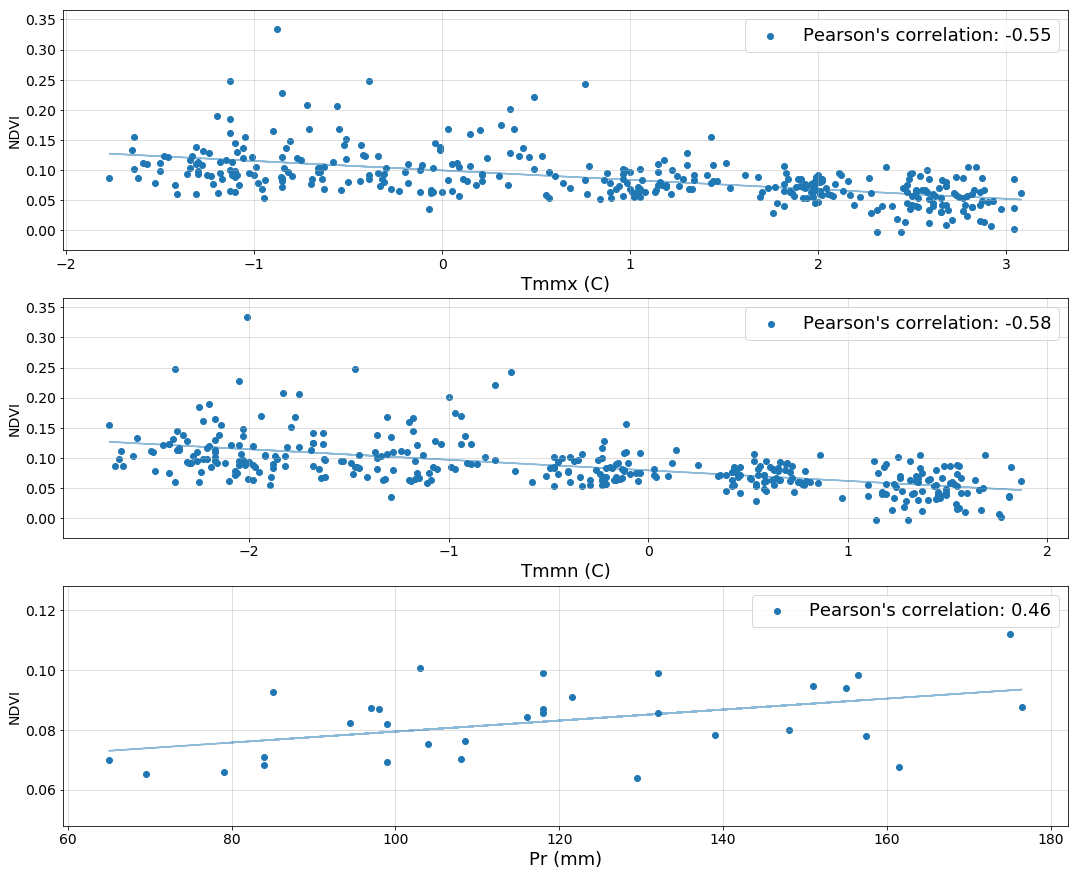

In [213]:
from scipy.stats import pearsonr
r = len(x)
labels = ['Tmmx (C)', 'Tmmn (C)', 'Pr (mm)']
f, ax = plt.subplots(r,1,figsize=(18,15))
for i in range(r):
    corr, _ = pearsonr(x[i], y[i])
    ax[i].scatter(x[i],y[i], label="Pearson's correlation: %0.2f"%(corr))
    # calculate Pearson's correlation
    z = np.polyfit(x[i], y[i], 1)
    p = np.poly1d(z)
    r2 = R2(x[i],y[i],1)['determination']
    ax[i].plot(x[i],p(x[i]),alpha=0.5)
    ax[i].grid(alpha=0.5)
    ax[i].legend(fontsize=18)
    ax[i].set_ylabel('NDVI', fontsize=14)
    ax[i].set_xlabel(labels[i], fontsize=18)
    ax[i].tick_params(axis='both', labelsize=14)
    f.savefig('./out/NDVI_correlation.png', dpi=200, bbox_inches='tight')

In [210]:
import statsmodels.api as sm
from sklearn import preprocessing
X = x.T 
normX = preprocessing.scale(X)

# Note the difference in argument order
model = sm.OLS(y[0], normX).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.075
Model:                            OLS   Adj. R-squared (uncentered):              0.067
Method:                 Least Squares   F-statistic:                              9.752
Date:                Sat, 17 Aug 2019   Prob (F-statistic):                    3.35e-06
Time:                        23:52:55   Log-Likelihood:                          352.49
No. Observations:                 364   AIC:                                     -699.0
Df Residuals:                     361   BIC:                                     -687.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1343      0.060      2.223      0.027       0.015       0.253
x2            -0.1611      0.063     -2.543      0.011      -0.286      -0.037
x3             0.0054      0.008      0.687      0.493      -0.010       0.021
==============================================================================
Omnibus:                      196.955   Durbin-Watson:                   0.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1559.934
Skew:                           2.158   Prob(JB):                         0.00
Kurtosis:                      12.177   Cond. No.                         29.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""